The following is an example of a positive enhancer sequence and a background sequence from the human genome.

In [3]:
bp_lengths = []
for i in range(61936):
    with open(f'human_enhancers_ensembl/train/positive/{i}.txt', 'r') as f_positive:
        for l in f_positive.readlines():
            bp_lengths.append(len(l))

for i in range(61936):
    with open('human_enhancers_ensembl/train/negative/2.txt') as f_negative:
        for l in f_negative.readlines():
            bp_lengths.append(len(l))

print('Max sequence length: ', max(bp_lengths))

Max sequence length:  573


### dna2vec k-mer encoder
This is one of the k-mer encoders that will be used on the input sequences

In [2]:
from gensim.models import KeyedVectors
import numpy as np

filepath = "dna2vec/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.w2v"

# These pretrained dna2vec files are in text word2vec format → binary=False
kv = KeyedVectors.load_word2vec_format(filepath, binary=False)

def vector(kmer: str):
    return kv[kmer]

def cosine_distance(a: str, b: str) -> float:
    # gensim gives cosine *similarity*, so distance = 1 - similarity
    return 1.0 - kv.similarity(a, b)

if __name__ == "__main__":
    print("AGCA vec:", vector("AGCA"))
    print("cosdist(AAA, GCT)  :", cosine_distance("AAA", "GCT"))
    print("cosdist(AAA, AAAA) :", cosine_distance("AAA", "AAAA"))


AGCA vec: [ 0.031934  0.440418 -0.150419  0.014716  0.119263  0.058114 -0.312005
 -0.161748 -0.349029 -0.266925  0.327924  0.058812  0.325346  0.555622
 -0.342733  0.174307  0.102776  0.135182 -0.391096 -0.116741  0.206415
 -0.28563   0.088689  0.040088 -0.027641 -0.275357 -0.14471   0.263251
  0.047554 -0.036737  0.364251 -0.116972  0.286012  0.103939 -0.00627
 -0.327004 -0.344822  0.100827 -0.284543  0.271215  0.070308  0.332634
  0.067491 -0.066082 -0.4517    0.00998  -0.48495   0.259643 -0.25499
 -0.117224 -0.292354 -0.142832  0.045673 -0.113715 -0.298148 -0.036117
 -0.082101  0.247983 -0.183166 -0.098923  0.641029  0.221092 -0.012978
  0.352521  0.554256  0.174414 -0.083894  0.358389  0.096209 -0.169332
 -0.18865   0.161321 -0.256877 -0.003476 -0.223552  0.038645 -0.307966
  0.373101  0.032724  0.271275 -0.099642  0.190561 -0.16275  -0.058928
 -0.348395  0.078296 -0.605732 -0.167607  0.028524  0.061146 -0.149679
  0.041624 -0.398863 -0.494398  0.326998 -0.088775  0.179929  0.22495

### Creating PyTorch training file

In [18]:
import torch
import numpy as np

VALID = set(["A", "C", "G", "T"])

sequences = []
labels = []

# Positive samples
for i in range(61936):
    path = f"human_enhancers_ensembl/train/positive/{i}.txt"
    with open(path, "r") as f:
        seq = f.readline().strip()

    # Validate length
    if len(seq) == 0:
        raise ValueError(f"Empty sequence in {path}")

    # Validate characters
    for c in seq:
        if c not in VALID:
            raise ValueError(f"Invalid character '{c}' in {path}")

    sequences.append(seq)
    labels.append(1)

# Negative samples
for i in range(61936):
    path = f"human_enhancers_ensembl/train/negative/{i}.txt"
    with open(path, "r") as f:
        seq = f.readline().strip()

    if len(seq) == 0:
        raise ValueError(f"Empty sequence in {path}")

    for c in seq:
        if c not in VALID:
            raise ValueError(f"Invalid character '{c}' in {path}")

    sequences.append(seq)
    labels.append(0)

torch.save({"seqs": sequences, "labels": labels}, "train_raw.pt")
print('Saved dataset to train_raw.pt')


ValueError: Invalid character 'N' in human_enhancers_ensembl/train/negative/260.txt

### Checking why there is an invalid character in one of the files

In [21]:
path = "human_enhancers_ensembl/train/negative/260.txt"
with open(path, 'r') as bf:
    for line in bf.readlines():
        print(line)

NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


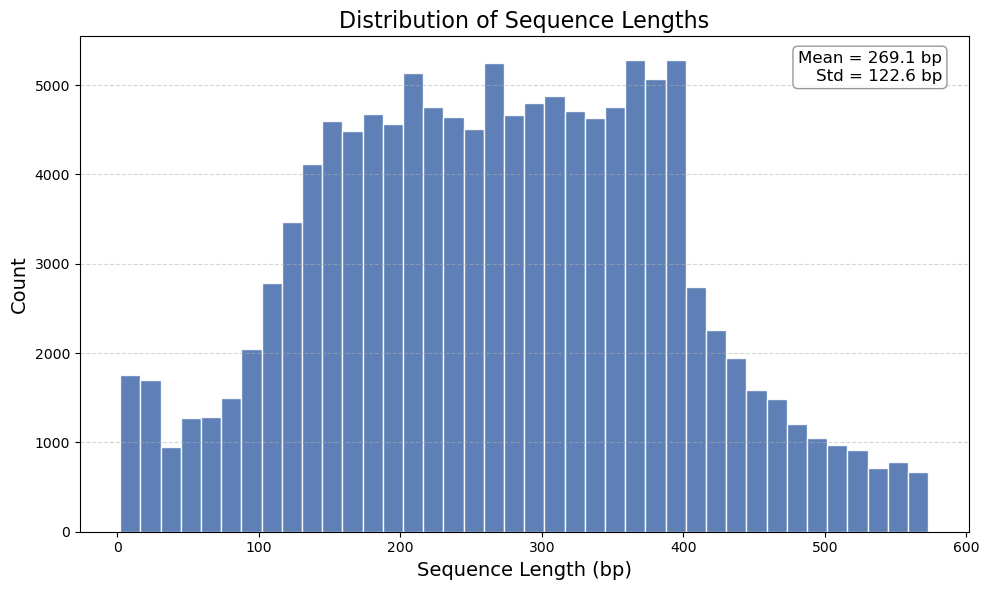

Mean length: 269.11
Std: 122.62
Percent <=400 bp: 0.865
Percent <=300 bp: 0.586
Percent <=200 bp: 0.314
Percent <=100 bp: 0.083


In [15]:
import numpy as np
import matplotlib.pyplot as plt

lengths = np.array([len(s) for s in sequences])

# Percentages
lt_400 = np.sum(lengths <= 400) / len(lengths)
lt_300 = np.sum(lengths <= 300) / len(lengths)
lt_200 = np.sum(lengths <= 200) / len(lengths)
lt_100 = np.sum(lengths <= 100) / len(lengths)

mean_len = lengths.mean()
std_len = lengths.std()

plt.figure(figsize=(10, 6))

plt.hist(
    lengths,
    bins=40,                    # good balance between detail + noise
    color="#4C72B0",            # seaborn-ish blue
    edgecolor="white",          # crisp visual
    alpha=0.9
)

plt.title("Distribution of Sequence Lengths", fontsize=16)
plt.xlabel("Sequence Length (bp)", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.5)

# Text box with mean + std
textstr = f"Mean = {mean_len:.1f} bp\nStd = {std_len:.1f} bp"
plt.text(
    0.97, 0.97, textstr,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

plt.tight_layout()
plt.savefig('training_data_distribution.png', dpi=250)
plt.show()

print(f"Mean length: {mean_len:.2f}")
print(f"Std: {std_len:.2f}")
print(f"Percent <=400 bp: {lt_400:.3f}")
print(f"Percent <=300 bp: {lt_300:.3f}")
print(f"Percent <=200 bp: {lt_200:.3f}")
print(f"Percent <=100 bp: {lt_100:.3f}")


### Need to check for invalid sequences - some were found in encoding process

In [17]:
VALID_CHARS = ['A', 'G', 'C', 'T']

def find_invalid_lines():
    error_files = []
    for i in range(61936):
        with open(f'human_enhancers_ensembl/train/negative/{i}.txt', 'r') as f_positive:
            for l in f_positive.readlines():
                for c in l:
                    if c not in VALID_CHARS:
                        print(f'Characer {c} for in file human_enhancers_ensembl/train/positive/{i}.txt')
                        error_files.append(i)

    """for i in range(61936):
        with open(f'human_enhancers_ensembl/train/negative/{i}.txt', 'r') as f_negative:
            for l in f_negative.readlines():
                sequences.append(l)
                labels.append(0)"""

## Count model parameters

In [23]:
from EnhancerAttention import EnhancerAttention

model = EnhancerAttention(embed_size=100)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 30501


## Prelimary Results on Test Set

Using device: cpu


/var/folders/hy/k_vp1md94sz2dr40dtrs6ln80000gn/T/ipykernel_36421/175589768.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=d

Test Metrics
------------
AUC:       0.7834
Accuracy:  0.7190
Precision: 0.7229
Recall:    0.7104
F1-score:  0.7166


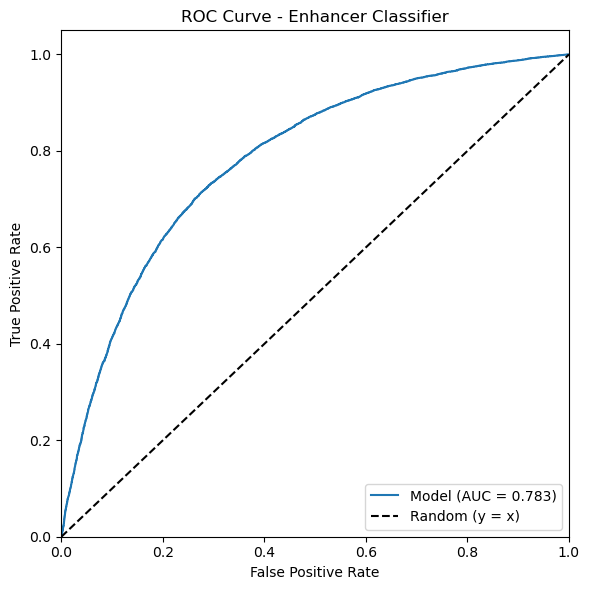

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from sklearn.metrics import (
    roc_curve,
    auc,
    accuracy_score,
    precision_recall_fscore_support
)

from gensim.models import KeyedVectors
from EnhancerAttention import EnhancerAttention
from EnhancerDataset import EnhancerDataset, enhancer_collate_fn


# -------- Evaluation script --------

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load model
    model_path = "preliminary_model.pth"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"{model_path} not found.")

    model = torch.load(model_path, map_location=device)
    model.eval()

    # Dataset
    test_dataset = EnhancerDataset(data_type="test")
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=enhancer_collate_fn,
    )

    all_labels = []
    all_logits = []

    with torch.no_grad():
        for inputs, masks, labels in test_loader:
            inputs = inputs.to(device) # (B, L, D)
            masks = masks.to(device) # (B, L)
            labels = labels.to(device) # (B,)

            logits = model(inputs, masks)  # (B,)
            all_labels.append(labels.cpu().numpy())
            all_logits.append(logits.cpu().numpy())

    y_true = np.concatenate(all_labels) # (N,)
    logits = np.concatenate(all_logits) # (N,)
    y_prob = 1 / (1 + np.exp(-logits)) # apply sigmoid to the logits
    y_pred = (y_prob >= 0.5).astype(np.int32)

    # Metrics

    # ROC + AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Accuracy, Precision, Recall, F1
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    print("Test Metrics")
    print("------------")
    print(f"AUC:       {roc_auc:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # ROC curve plot with y = x

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"Model (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random (y = x)")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Enhancer Classifier")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png", dpi=300)
    plt.show()


if __name__ == "__main__":
    main()
